# Hugoniot for Hydrogen/Deuterium
Purpose of this notebook is to do Hugoniot calculations for Deuterium

["Monte Carlo results for the hydrogen Hugoniot"-
V. Bezkrovniy, V. S. Filinov, D. Kremp, M. Bonitz, M. Schlanges, W. D. Kraeft, P. R. Levashov, and V. E. Fortov
Phys. Rev. E 70, 057401 – Published 18 November 2004
](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.70.057401)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")


ModuleNotFoundError: No module named 'mendeleev'


# Hugoniot Description and Assumptions

From "Monte Carlo results for the hydrogen Hugoniot", we assume the hock Hugoniot curve is given by (note there is a sign typo in the paper)
$$H = E-E_0 + \frac{1}{2}(p+p_0)(V-V_0)= 0
$$
With initial conditions given by
\begin{align}
p_0 = 0,\  \rho_0 = 0.171 \textrm{ g/cm$^3$}, \ E_0 = -15.887 \textrm{ eV/atom}
\end{align}

Say we compute E(n, T), P(n, T) then we have 2 free parameters, potentially plotted in P, n space. Instead, we constrain with 1 equation, that given above.

The paper goes from $\sim 10^4 \to 10^6 $ K, and rs from $1.7 \to 2$

In [2]:
ρ0 = 0.171 # g/cc
n0_AU = ρ0/ (2*m_p*AU_to_g)/cm_to_AU**3
E0_eV = -15.886 # eV
E0_AU = E0_eV*eV_to_AU
P0_AU=0
Hugoniot_func  = lambda T, n, P, E: E - E0_AU + 0.5 * (P+P0_AU)*(1/n - 1/n0_AU)
Hugoniot_func = np.vectorize(Hugoniot_func)

### Set Parameters in Paper and Plot

In [3]:
name = 'Hydrogen'
Z, A = 1,1 

Te_eV_list = np.geomspace(0.05, 5e2, num=10) #np.array(GP_Te_eV) # eV
# Te_eV_list = np.array([15.625e3, 31.250e3, 62.500e3, 1.25e5, 2.5e5, 5e5, 1e6])/eV_to_K
Ti_eV_list = Te_eV_list

# ri_cm = rs_from_n(ni_cc)  # cm
ρ_gpercc_list = np.linspace(0.2, 1.5, num=10)#n_from_rs(ri_AU/cm_to_AU)*
ni_cc_list = ρ_gpercc_list*1/(2*m_p*AU_to_g)
ri_cm_list = rs_from_n(ni_cc_list)
ri_AU_list = ri_cm_list*cm_to_AU
# ri_AU_list = np.array([1.7, 1.86, 2.])
print("ri: ", ri_AU_list, "Te: ", Te_eV_list)

ri:  [2.9964575  2.4998372  2.22440945 2.04051914 1.90545901 1.80027808
 1.71504379 1.64395575 1.58335761 1.5308091 ] Te:  [5.00000000e-02 1.39127970e-01 3.87131841e-01 1.07721735e+00
 2.99742125e+00 8.34050269e+00 2.32079442e+01 6.45774833e+01
 1.79690683e+02 5.00000000e+02]


#### Run Ornstein-Zernike Closure

In [4]:
P_hnc_to_AU   = lambda P_hnc, ri: (P_hnc/ri**3) 
P_hnc_to_Mbar = lambda P_hnc, ri: P_hnc_to_AU(P_hnc, ri)*AU_to_bar/1e6
P_hnc_to_GPa = lambda P_hnc, ri: P_hnc_to_AU(P_hnc, ri)*AU_to_Pa/1e9

def plasma_output(plasma):
    plasma.run_hnc()
    try: 
        plasma.hnc.βu_r_matrix[1,1] -= plasma.βP_ee
    except:
        plasma.hnc.βu_r_matrix[1,1] -= plasma.qsp.βv_Pauli(plasma.hnc.r_array, plasma.qsp.Λee)
    P_hnc, E_density_hnc  = plasma.hnc.total_pressure(),  plasma.hnc.total_energy_density() 
    E_AU = E_density_hnc/plasma.hnc.rho[0]
    P_AU = P_hnc_to_AU(P_hnc, plasma.qsp.ri)
    try: 
        plasma.hnc.βu_r_matrix[1,1] += plasma.βP_ee
    except:
        plasma.hnc.βu_r_matrix[1,1] += plasma.qsp.βv_Pauli(plasma.hnc.r_array, plasma.qsp.Λee)
    
    return P_AU, E_AU 

name1 = 'OZ - g'
plasma1 = lambda T_eV, ni_cc: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'geometric'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})
name2 = 'OZ - th'
plasma2 = lambda T_eV, ni_cc: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'thermal'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})
name3 = 'OZ - th  Pauli'
plasma3 = lambda T_eV, ni_cc: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z, find_βuee=True,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'thermal'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})
name4 = 'SVT - th'
plasma4 =  lambda T_eV, ni_cc: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'svt'},
                 hnc_solve_options={'alpha_Picard':0.5,'num_iterations':1e4})

### Make Hugoniot Interpolation Table

#### Compute all plasma models for grid of T and ρ

In [ ]:
PE_list_1 = []
PE_list_2 = []
PE_list_3 = []
PE_list_4 = []

for T_eV in Te_eV_list:
    for rs in ri_AU_list:
        ni_cc = n_from_rs(rs)*cm_to_AU**3
        #1
        # plasma = plasma1(T_eV, ni_cc)
        # Pe_id, Pe_ex, Pe = plasma_output(plasma)
        # P_list_1.append( [Pe_id, Pe_ex, Pe] )
        #2
        # plasma = plasma2(T_eV, ni_cc)
        # Pe_id, Pe_ex, Pe = plasma_output(plasma)
        # P_list_2.append( [Pe_id, Pe_ex, Pe] )
        #3
        plasma = plasma3(T_eV, ni_cc)
        P_AU, E_AU  = plasma_output(plasma)
        PE_list_3.append( [T_eV*eV_to_AU, ni_cc/cm_to_AU**3, P_AU, E_AU ] )
        #4
        # plasma = plasma4(T_eV, ni_cc)
        # Pe_id, Pe_ex, Pe = plasma_output(plasma)
        # P_list_4.append( [Pe_id, Pe_ex, Pe] )
    

Te_in_eV: 0.050
Ti_in_eV: 0.050


/home/zach/plasma/hnc/hnc/PIE.py:186: RuntimeWarning: overflow encountered in exp
  integrand = lambda t: t*np.sin(sin_arg*t)/(1+np.exp(t**2-η))


Now Plot 

In [ ]:
PE_list_1 = np.array(PE_list_1)
PE_list_2 = np.array(PE_list_2)
PE_list_3 = np.array(PE_list_3)
PE_list_4 = np.array(PE_list_4)

In [ ]:
H_list = Hugoniot_func(*PE_list_3.T)
H_list

In [ ]:
import numpy as np
from tabulate import tabulate

def generate_latex_table(data):
    data = data.reshape(len(Te_eV_list), len(ri_AU_list),4)
    # Assuming data is your NT x Nr x 4 tensor
    # Replace the following line with your actual data
    # data = np.random.rand(7, 3, 4)  # Example data: 7 Ts, 3 rs, and 4 values in the last dimension

    # Extract the unique T and r values, and the P and E values
    T_values = data[:, 0, 0]/eV_to_AU*eV_to_K
    ni_AU_values = data[0, :, 1]
    r_values = rs_from_n(ni_AU_values)
    P_values = data[:, :, 2]*AU_to_Pa/1e9
    E_values = data[:, :, 3]/eV_to_AU

    # Create the table headers
    headers = ["$T$ [K]"]
    for r in r_values:
        headers.extend([f"($r_s={r:0.2f}$): $P$ [GPa]", f"$E$ [eV]"])

    # Create the table rows
    table_rows = []
    for i, T in enumerate(T_values):
        row = [f"{T}"]
        for j in range(len(r_values)):
            row.extend([f"{P_values[i, j]:.2f}", f"{E_values[i, j]:.2f}"])
        table_rows.append(row)

    # Generate the LaTeX code
    latex_table = tabulate(table_rows, headers, tablefmt="latex_raw")

    # Manually adjust the LaTeX code to add the rs line
    rs_line = " & " + " & ".join([f"\\multicolumn{{2}}{{c|}}{{$r_s={r}$}}" for r in r_values]) + " \\\\ \n"
    latex_table = latex_table.replace("\\toprule", "\\toprule" + rs_line)

    # Print the LaTeX code
    print(latex_table)

# Replace with your actual data
generate_latex_table(PE_list_3)


In [ ]:
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator


fig, ax = plt.subplots(figsize=(10,8))

ρ_gpercc = 2*PE_list_3[:,1]*( (m_p*AU_to_g)*cm_to_AU**3)
P_GPa = PE_list_3[:,2]*AU_to_Pa/1e9

ρ_mesh, P_mesh = np.meshgrid(np.linspace( np.min(ρ_gpercc), np.max(ρ_gpercc),num=100), np.geomspace( np.min(np.abs(P_GPa)), np.max(P_GPa),num=100) )

z = H_list
# H_interp = CloughTocher2DInterpolator(list(zip(ρ_gpercc, P_GPa)), z)
# H_mesh = H_interp(ρ_mesh, P_mesh)

H_interp = LinearNDInterpolator(list(zip(ρ_gpercc, np.log10(np.abs(P_GPa)))), z, )
H_mesh = H_interp(ρ_mesh, np.log10(np.abs(P_mesh)))

cmesh = plt.pcolormesh(ρ_mesh, P_mesh, H_mesh, shading='auto')
cntr2 = ax.contour(ρ_mesh, P_mesh, H_mesh, levels=[-0.1,0,0.1],colors='k', linestyles=['--','-','--'])#, cmap="RdBu_r")

ax.plot(ρ_gpercc, P_GPa, 'ko', ms=5)

ax.set_yscale('log')

ax.set_ylim(np.min(np.abs(P_GPa))*0.9, np.max(P_GPa)*1.1)
ax.set_xlim(np.min(ρ_gpercc)*0.9, np.max(ρ_gpercc)*1.1)

ax.set_xlabel(r"$\rho$ [g/cc]", fontsize=20)
ax.set_ylabel(r"$P$ [GPa]", fontsize=20)

plt.subplots_adjust(hspace=0.5)

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ρ_gpercc = 2*PE_list_3[:,1]*( (m_p*AU_to_g)*cm_to_AU**3)
P_GPa = PE_list_3[:,2]*AU_to_Pa/1e9
z = H_list
# z = np.log10(np.abs(H_list))
ax.tricontour(ρ_gpercc, np.log10(np.abs(P_GPa)) , z, levels=[-0.1,0,0.1], linewidths=0.5, colors='k')
cntr2 = ax.tricontourf(ρ_gpercc, np.log10(np.abs(P_GPa)), z, levels=100, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax)

ax.plot(ρ_gpercc, np.log10(P_GPa), 'ko', ms=5)

# ax.set_yscale('log')

# ax.set_ylim(np.min(P_GPa)*0.9, np.max(P_GPa)*1.1)
ax.set_xlim(np.min(ρ_gpercc)*0.9, np.max(ρ_gpercc)*1.1)

ax.set_xlabel(r"$\rho$ [g/cc]", fontsize=20)
ax.set_ylabel(r"$P$ [GPa]", fontsize=20)

plt.subplots_adjust(hspace=0.5)
plt.show()


## Try Root Finding Hugoniot

In [5]:
from scipy.optimize import root_scalar

def get_Hugoniot_ρ_at_T( T_eV, plasma_type=plasma3, ρ_gpercc_guess = 0.5):
    
    def find_ρ(ρ_gpercc):
        ni_cc = ρ_gpercc/ (2*m_p*AU_to_g)
        plasma = plasma_type(T_eV, ni_cc)
        P_AU, E_AU  = plasma_output(plasma)
        info = np.array([T_eV*eV_to_AU, ni_cc/cm_to_AU**3, P_AU, E_AU ])
        H = Hugoniot_func(*info)
        print(f"For ρ = {ρ_gpercc:.2f} [g/cc], H={H:.3f} [AU], P={P_AU*AU_to_Pa/1e9} [GPa], E={E_AU*AU_to_eV} [eV]" )
        return H
    sol = root_scalar(find_ρ, x0=0.5, x1=1.0, xtol=0.01)
    ρ_at_H = sol.root
    P_at_H, E_at_H = plasma_output(plasma_type(T_eV, ρ_at_H/ (2*m_p*AU_to_g) ))
    info = (T_eV, ρ_at_H, P_at_H, E_at_H  )
    H_at_H = Hugoniot_func(T_eV*eV_to_AU, ρ_at_H/ (2*m_p*AU_to_g)/cm_to_AU**3, P_at_H, E_at_H )
    print(f"Converged: ρ = {ρ_at_H:.2f} [g/cc], H={H_at_H:.3f} [AU], P={P_at_H*AU_to_Pa/1e9} [GPa], E={E_at_H*AU_to_eV} [eV]\n" )
    
    return sol, info

# Now find for many different temperatures
T_array = np.geomspace(2*300/eV_to_K, 5e2, num = 10 ) 
H_info_list  = []
for T in T_array:
    H_info_list.append( get_Hugoniot_ρ_at_T(T)[1] )

Te_in_eV: 0.052
Ti_in_eV: 0.052


/home/zach/plasma/hnc/hnc/PIE.py:186: RuntimeWarning: overflow encountered in exp
  integrand = lambda t: t*np.sin(sin_arg*t)/(1+np.exp(t**2-η))
/home/zach/plasma/hnc/hnc/PIE.py:193: RuntimeWarning: overflow encountered in exp
  f_of_k = 1/(  1+np.exp((dense_hnc.k_array/self.qsp.ri)**2/(2*m_e*self.qsp.Te) - η) )


0: Initial condition Total Error: 1.733e+01
Exiting status 0, reverting to best index so far: 1556
Final iter:1557, Total Error: 9.969e-09
For ρ = 0.50 [g/cc], H=0.146 [AU], P=-218.28839184433227 [GPa], E=-20.670846814978905 [eV]
Te_in_eV: 0.052
Ti_in_eV: 0.052
0: Initial condition Total Error: 2.007e+01
Exiting status 0, reverting to best index so far: 1940
Final iter:1941, Total Error: 9.993e-09
For ρ = 1.00 [g/cc], H=0.429 [AU], P=-300.69253285780724 [GPa], E=-19.402502262875494 [eV]
Te_in_eV: 0.052
Ti_in_eV: 0.052
0: Initial condition Total Error: 1.488e+01
Exiting status 0, reverting to best index so far: 1229
Final iter:1230, Total Error: 9.893e-09
For ρ = 0.24 [g/cc], H=-0.141 [AU], P=-141.18655671242584 [GPa], E=-22.247955642849945 [eV]
Te_in_eV: 0.052
Ti_in_eV: 0.052
0: Initial condition Total Error: 1.678e+01
Exiting status 0, reverting to best index so far: 1482
Final iter:1483, Total Error: 9.914e-09
For ρ = 0.43 [g/cc], H=0.083 [AU], P=-199.95408041203984 [GPa], E=-20.9537

/home/zach/plasma/hnc/hnc/misc.py:32: RuntimeWarning: invalid value encountered in scalar power
  return (4/3*π*n)**(-1/3)
/home/zach/plasma/hnc/hnc/qsps.py:53: RuntimeWarning: invalid value encountered in scalar power
  self.E_F = 1/(2*m_e) * (3*π**2 * self.ne)**(2/3)
/home/zach/plasma/hnc/hnc/misc.py:7: RuntimeWarning: invalid value encountered in scalar power
  E_F = 1/(2*m_e) * (3*π**2 * ne)**(2/3)
/home/zach/plasma/hnc/hnc/qsps.py:66: RuntimeWarning: invalid value encountered in sqrt
  self.lambda_TF = np.sqrt( self.Te / (4*π*self.ne)  )
/home/zach/anaconda3/envs/zplasma/lib/python3.10/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in Fonehalf (vectorized)
  outputs = ufunc(*inputs)


0: Initial condition Total Error: nan
QUIT: c_r is nan.
Exiting status 1, reverting to best index so far: 0
Final iter:1, Total Error: nan
For ρ = nan [g/cc], H=nan [AU], P=nan [GPa], E=nan [eV]
Te_in_eV: 3.054
Ti_in_eV: 3.054
0: Initial condition Total Error: nan
QUIT: c_r is nan.
Exiting status 1, reverting to best index so far: 0
Final iter:1, Total Error: nan
For ρ = nan [g/cc], H=nan [AU], P=nan [GPa], E=nan [eV]
Te_in_eV: 3.054
Ti_in_eV: 3.054
0: Initial condition Total Error: nan
QUIT: c_r is nan.
Exiting status 1, reverting to best index so far: 0
Final iter:1, Total Error: nan
For ρ = nan [g/cc], H=nan [AU], P=nan [GPa], E=nan [eV]
Te_in_eV: 3.054
Ti_in_eV: 3.054
0: Initial condition Total Error: nan
QUIT: c_r is nan.
Exiting status 1, reverting to best index so far: 0
Final iter:1, Total Error: nan
For ρ = nan [g/cc], H=nan [AU], P=nan [GPa], E=nan [eV]
Te_in_eV: 3.054
Ti_in_eV: 3.054
0: Initial condition Total Error: nan
QUIT: c_r is nan.
Exiting status 1, reverting to best 

/home/zach/plasma/hnc/hnc/PIE.py:187: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  κ = 3*(2*self.qsp.Te*m_e) / (self.qsp.k_F**3 * r) *quad(integrand, 0, t_max)[0]
/home/zach/plasma/hnc/hnc/PIE.py:187: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  κ = 3*(2*self.qsp.Te*m_e) / (self.qsp.k_F**3 * r) *quad(integrand, 0, t_max)[0]


0: Initial condition Total Error: 1.136e-01
Exiting status 0, reverting to best index so far: 23
Final iter:24, Total Error: 9.742e-09
For ρ = 0.50 [g/cc], H=2.861 [AU], P=3044.0512323314356 [GPa], E=184.04535621908073 [eV]
Te_in_eV: 65.060
Ti_in_eV: 65.060
0: Initial condition Total Error: 1.157e-01
Exiting status 0, reverting to best index so far: 23
Final iter:24, Total Error: 9.390e-09
For ρ = 1.00 [g/cc], H=-4.022 [AU], P=6054.961379166699 [GPa], E=180.62642844244814 [eV]
Te_in_eV: 65.060
Ti_in_eV: 65.060
0: Initial condition Total Error: 1.149e-01
Exiting status 0, reverting to best index so far: 23
Final iter:24, Total Error: 9.543e-09
For ρ = 0.71 [g/cc], H=-0.013 [AU], P=4297.125786232029 [GPa], E=182.39575772971926 [eV]
Te_in_eV: 65.060
Ti_in_eV: 65.060
0: Initial condition Total Error: 1.149e-01
Exiting status 0, reverting to best index so far: 23
Final iter:24, Total Error: 9.543e-09
Converged: ρ = 0.71 [g/cc], H=0.000 [AU], P=4291.30174774196 [GPa], E=182.4025208363251 [eV

### Plot Hugoniot

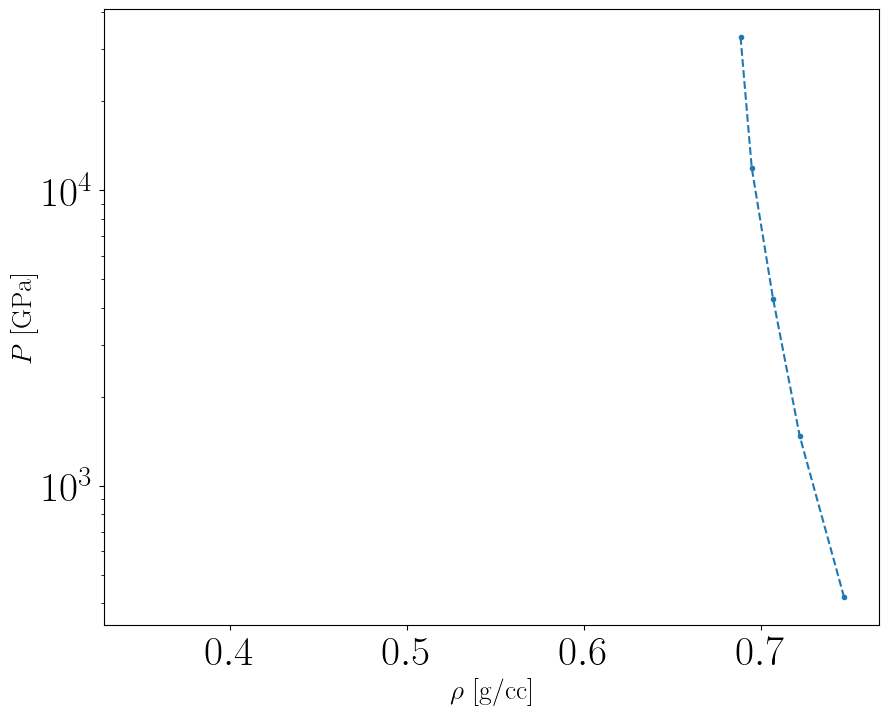

In [6]:
fig, ax = plt.subplots(figsize=(10,8))

H_ρ_gpercc_vals = np.array(H_info_list)[:,1]
H_P_GPa_vals = np.array(H_info_list)[:,2]*AU_to_Pa/1e9
ax.plot(H_ρ_gpercc_vals, H_P_GPa_vals,'--.')

ax.set_yscale('log')

# ax.set_ylim(np.min(P_GPa)*0.9, np.max(P_GPa)*1.1)
# ax.set_xlim(np.min(ρ_gpercc)*0.9, np.max(ρ_gpercc)*1.1)

ax.set_xlabel(r"$\rho$ [g/cc]", fontsize=20)
ax.set_ylabel(r"$P$ [GPa]", fontsize=20)

plt.subplots_adjust(hspace=0.5)
plt.show()

##### Diagnosing Low T Issues

In [7]:
plasma_test = lambda T_eV, ni_cc: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z, find_βuee=True,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'thermal'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':10,'N_bins':500, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})


In [8]:
plasma_type=plasma_type=plasma_test

ρ_gpercc = 0.44
T_eV = 2000/eV_to_K

ni_cc = ρ_gpercc/ (2*m_p*AU_to_g)
plasma = plasma_type(T_eV, ni_cc)
P_AU, E_AU  = plasma_output(plasma)
info = np.array([T_eV*eV_to_AU, ni_cc/cm_to_AU**3, P_AU, E_AU ])
H = Hugoniot_func(*info)
print(f"For ρ = {ρ_gpercc:.2f} [g/cc], H={H:.3f} [AU], P={P_AU*AU_to_Pa/1e9} [GPa], E={E_AU*AU_to_eV} [eV]" )

Te_in_eV: 0.172
Ti_in_eV: 0.172


/home/zach/plasma/hnc/hnc/PIE.py:186: RuntimeWarning: overflow encountered in exp
  integrand = lambda t: t*np.sin(sin_arg*t)/(1+np.exp(t**2-η))
/home/zach/plasma/hnc/hnc/PIE.py:193: RuntimeWarning: overflow encountered in exp
  f_of_k = 1/(  1+np.exp((dense_hnc.k_array/self.qsp.ri)**2/(2*m_e*self.qsp.Te) - η) )


0: Initial condition Total Error: 1.071e+01
Exiting status 0, reverting to best index so far: 508
Final iter:509, Total Error: 9.970e-09
For ρ = 0.44 [g/cc], H=0.075 [AU], P=-195.60135656457246 [GPa], E=-21.13621493642142 [eV]


In [9]:
plasma_type=plasma_test
ρ_gpercc = 0.47
T_eV = 2000/eV_to_K

ni_cc = ρ_gpercc/ (2*m_p*AU_to_g)
plasma = plasma_type(T_eV, ni_cc)
P_AU, E_AU  = plasma_output(plasma)
info = np.array([T_eV*eV_to_AU, ni_cc/cm_to_AU**3, P_AU, E_AU ])
H = Hugoniot_func(*info)
print(f"For ρ = {ρ_gpercc:.2f} [g/cc], H={H:.3f} [AU], P={P_AU*AU_to_Pa/1e9} [GPa], E={E_AU*AU_to_eV} [eV]" )

Te_in_eV: 0.172
Ti_in_eV: 0.172
0: Initial condition Total Error: 1.087e+01
Exiting status 0, reverting to best index so far: 520
Final iter:521, Total Error: 9.774e-09
For ρ = 0.47 [g/cc], H=0.102 [AU], P=-203.18168192395922 [GPa], E=-20.994903497646526 [eV]


In [10]:
plasma_type=plasma_type=plasma_test

ρ_gpercc = 1.1
T_eV = 2000/eV_to_K

ni_cc = ρ_gpercc/ (2*m_p*AU_to_g)
plasma = plasma_type(T_eV, ni_cc)
P_AU, E_AU  = plasma_output(plasma)
info = np.array([T_eV*eV_to_AU, ni_cc/cm_to_AU**3, P_AU, E_AU ])
H = Hugoniot_func(*info)
print(f"For ρ = {ρ_gpercc:.2f} [g/cc], H={H:.3f} [AU], P={P_AU*AU_to_Pa/1e9} [GPa], E={E_AU*AU_to_eV} [eV]" )

Te_in_eV: 0.172
Ti_in_eV: 0.172
0: Initial condition Total Error: 1.317e+01
Exiting status 0, reverting to best index so far: 682
Final iter:683, Total Error: 9.814e-09
For ρ = 1.10 [g/cc], H=0.434 [AU], P=-293.9458255406018 [GPa], E=-19.2168652469881 [eV]
